In [2]:
from obspy import UTCDateTime
import obspy as obs
from obspy.clients.fdsn import Client as FDSN_Client
import numpy as np


In [3]:
t1 = UTCDateTime("2009-03-24")
t2 = UTCDateTime("2009-03-30")
stname = ['SND']
network = 'AZ'
org = 'IRIS'

client = FDSN_Client(org)


for i, comp in enumerate(['HHE', 'HHN', 'HHZ']):
  land_st1 = client.get_waveforms(network, str(stname[0]), "*", str(comp), t1, t2)
  if i==0:
    st=land_st1
  else:
    st+=land_st1

st_original = st.copy()
st = st_original.copy()
st.detrend()
st.taper(max_percentage=0.05)
st.filter('highpass', freq=2)



3 Trace(s) in Stream:
AZ.SND..HHE | 2009-03-24T00:00:00.000000Z - 2009-03-30T00:00:00.000000Z | 100.0 Hz, 51840001 samples
AZ.SND..HHN | 2009-03-24T00:00:00.000000Z - 2009-03-30T00:00:00.000000Z | 100.0 Hz, 51840001 samples
AZ.SND..HHZ | 2009-03-24T00:00:00.000000Z - 2009-03-30T00:00:00.000000Z | 100.0 Hz, 51840001 samples

In [4]:
#Pick phases
import torch
import seisbench
import seisbench.models as sbm
import pandas as pd

#define models
picker = sbm.PickBlue("phasenet")

if torch.cuda.is_available():
    picker.cuda()

#Threshold of the probability of S and P phases to identify events
pmin=0.5
smin=0.5

picks = picker.classify(st, batch_size=256, P_threshold=pmin, S_threshold=smin).picks

    # convert the picks and station metadata into pandas dataframes
pick_df = []
pick_df_remain = []
for i,p in enumerate(picks):
    pick_df.append({
        "pick_idx":i,
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "amp":0.0,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })
pick_df = pd.DataFrame(pick_df)


2025-05-06 05:58:36,311 | seisbench | WARNING | You are processing a large stream with the sequential asyncio implementation. Consider activating parallelisation. For details, see http://docs.seisbench.org/en/stable/pages/documentation/models.html#seisbench.models.base.WaveformModel.annotate


In [11]:
#Exclude bad events
#Only use events which have s and p phases
from datetime import timedelta

#Threshold of maximum S-P time 
max_pstime=7


hyp_df=[]
pflg=0
ev_id=0
for index,row in pick_df.iterrows():
    if row['type']=='p':
        ptime=row['timestamp']
        pflg=1
    if pflg==1 and row['type']=='s' and row['timestamp']-timedelta(seconds=max_pstime)<ptime:
        hyp_df.append({
                "ev_id":ev_id,
                "ptime":ptime,
                'pstime':UTCDateTime(row['timestamp'])-UTCDateTime(ptime)
            })
        pflg=0
        ev_id+=1
    
hyp_df = pd.DataFrame(hyp_df)   

In [12]:
print(hyp_df)

print(pick_df)
print(pick_df[(pick_df['type']=='p')])

   ev_id                   ptime  pstime
0      0 2009-03-25 07:06:49.590    6.95
1      1 2009-03-25 12:41:38.090    2.69
2      2 2009-03-25 16:31:31.330    4.23
3      3 2009-03-26 12:25:28.230    3.56
4      4 2009-03-26 16:12:57.690    6.32
5      5 2009-03-26 18:48:03.130    1.15
6      6 2009-03-27 02:52:15.600    5.03
7      7 2009-03-27 06:31:49.270    4.88
8      8 2009-03-28 02:25:06.660    5.49
9      9 2009-03-28 05:33:43.210    2.19
     pick_idx       id               timestamp  amp      prob type
0           0  AZ.SND. 2009-03-24 00:37:57.180  0.0  0.535632    s
1           1  AZ.SND. 2009-03-24 00:52:48.800  0.0  0.685224    s
2           2  AZ.SND. 2009-03-24 01:23:25.400  0.0  0.619705    s
3           3  AZ.SND. 2009-03-24 01:57:32.100  0.0  0.622561    s
4           4  AZ.SND. 2009-03-24 02:24:54.080  0.0  0.562508    s
..        ...      ...                     ...  ...       ...  ...
626       626  AZ.SND. 2009-03-29 22:50:16.090  0.0  0.674696    s
627       627

In [7]:

selected_times = np.random.choice(land_st1[0].times(), 100, replace=False)


In [8]:
import sys
sys.path.append("../")
from ground_motion_qh import extract_pairs

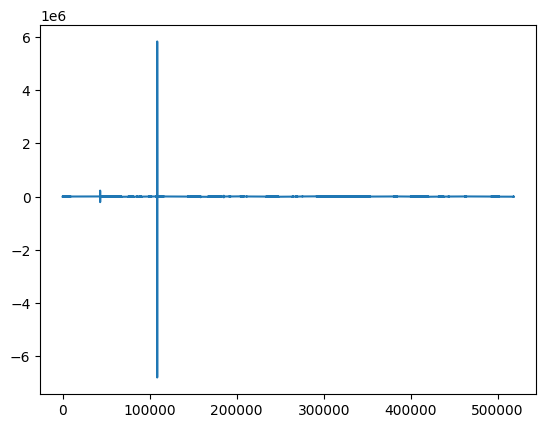

In [9]:
from matplotlib import pyplot as plt

plt.plot(
    land_st1[0].times(),
    land_st1[0].data
)

0.91

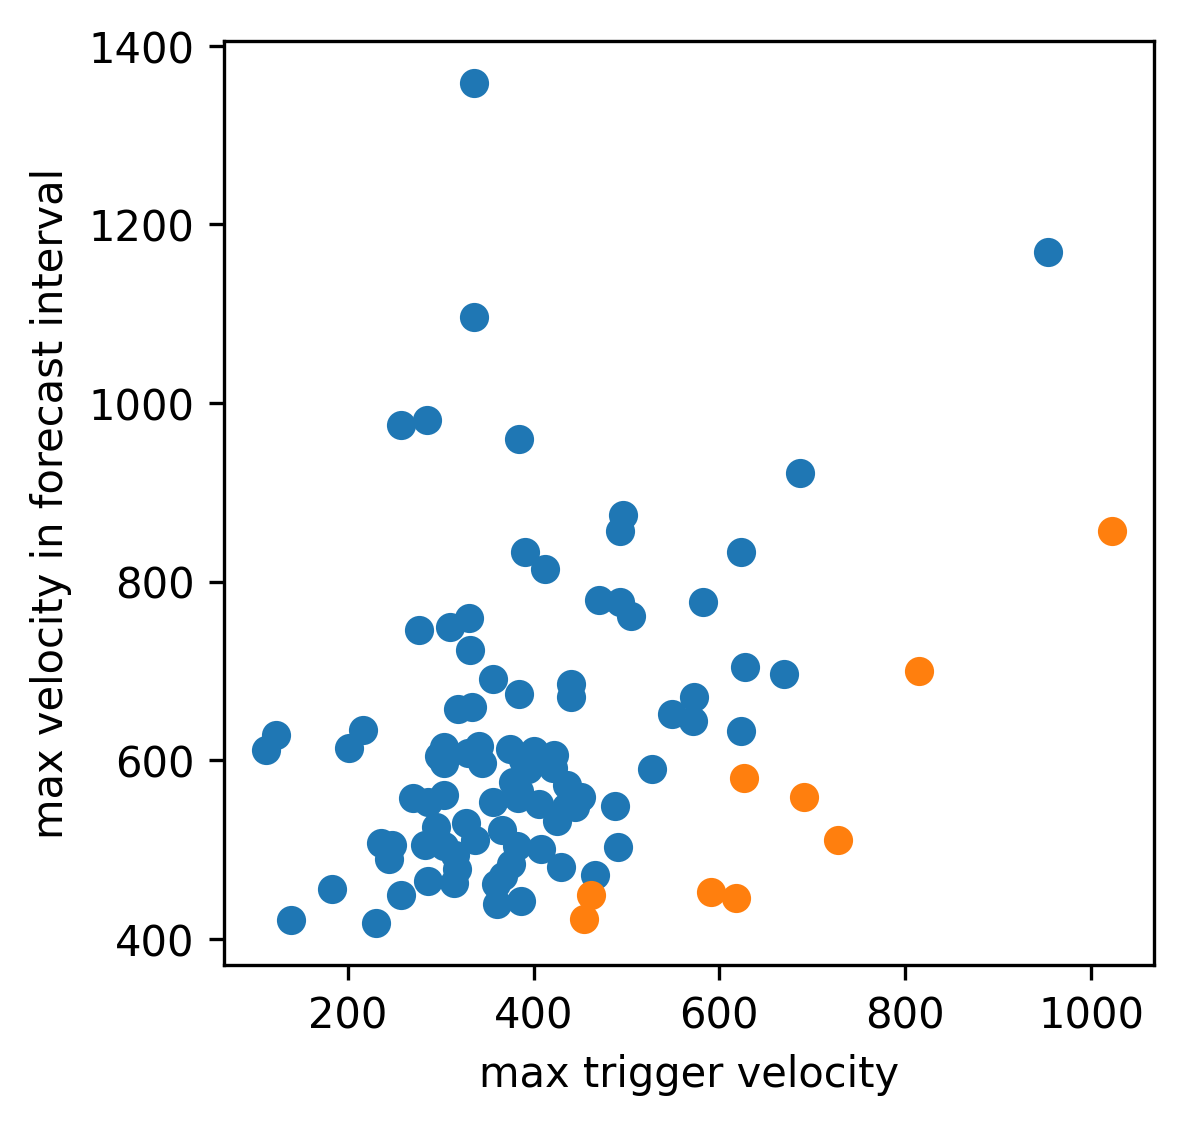

In [10]:

a_minus_vector, a_plus_vector = extract_pairs.waveform_to_max_amp_pairs(
    selected_times,
    land_st1[0].data,
    land_st1[0].times(),
    # tw_minus=TW_MINUS,
    # tw_plus=TW_PLUS,
    # tw_buffer=TW_BUFFER,
)
above_logical = a_plus_vector>a_minus_vector

fig, ax = plt.subplots(dpi=300, figsize = (4,4))
ax.scatter(a_minus_vector[above_logical], a_plus_vector[above_logical])
ax.scatter(a_minus_vector[~above_logical], a_plus_vector[~above_logical])
ax.set_xlabel('max trigger velocity')
ax.set_ylabel('max velocity in forecast interval')
np.mean(a_plus_vector>a_minus_vector)